In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from lidar.lidar import Lidar2D, OnlineTrajectoryLidarDataset
import glob
import numpy as np
import os

In [2]:
# Settings
data_dir = "./32_data"
waypoint_subdir = "some_overlap" #minimal_overlap, some_overlap, tight_paths
img_path = os.path.join(data_dir, "floor_img.png")
num_beams = 20
beam_samps = 5 # Number of samples in an individual beam
beam_length = 0.2
spline_res = 30
samp_distribution_factor = 1.0
collision_samps = 50
fine_samps = 3
num_scans_in_window = 30
spline_res = 30

# Setup Lidar Object
lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps,
    samp_distribution_factor, collision_samps, fine_samps, border_width=30)

# Waypoint Settings
wp_names = glob.glob1(os.path.join(data_dir, waypoint_subdir), "*.npy") 

datasets = []
for wp_name in wp_names:
    wp_path = os.path.join(data_dir, waypoint_subdir, wp_name)
    wps = np.load(wp_path)
    ds = OnlineTrajectoryLidarDataset(lidar, wps, 
        spline_res, num_scans_in_window)
    datasets.append(ds)

In [3]:
fpoint = datasets[0].scan_locs[1000,:]
nf = 1000; n = len(datasets)
member = np.zeros((nf, n))

fpoint_dist = []
for agent_id, ds in enumerate(datasets):
    trajectory = ds.scan_locs
    distances = np.linalg.norm(trajectory - fpoint, axis=1)
    min_dist = min(distances)
    fpoint_dist.append(min_dist)
    if min_dist<100:
        member[0, agent_id] = 1
    print ('Trajectory', trajectory.shape) # 1e6 calculations are fine.
if sum(member[0,:]) == 0:
    member[0, fpoint_dist.index(min(fpoint_dist))] = 1

Trajectory (1230, 2)
Trajectory (1350, 2)
Trajectory (1350, 2)
Trajectory (1350, 2)
Trajectory (1410, 2)
Trajectory (1500, 2)
Trajectory (1440, 2)


In [4]:
# plt.plot(distances)
print(datasets[0].scan_locs)

[[965.95062886 537.35711174]
 [964.31414723 539.66551036]
 [962.47456279 541.93066457]
 ...
 [967.6622954  527.05007216]
 [966.82077652 532.12646131]
 [965.95062886 537.35711174]]


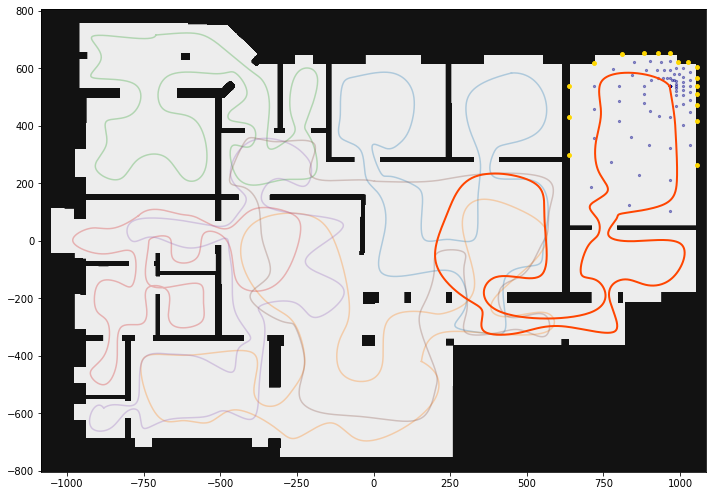

In [5]:
(fig, ax) = plt.subplots(figsize=(10,7), tight_layout=True)
X, Y = np.meshgrid(lidar.xs, lidar.ys)
ax.contourf(X, Y, lidar.img, cmap=cm.binary, zorder=0)

highlight_agent = 0
ax.plot(datasets[highlight_agent].scan_locs[:, 0], datasets[highlight_agent].scan_locs[:, 1],
    c="orangered", linewidth=2, zorder=3)
scan_points = datasets[0].scans[:datasets[0].scan_size, :]
ld_points = scan_points[scan_points[:, 2] != 1.0]
hd_points = scan_points[scan_points[:, 2] == 1.0]
ax.scatter(ld_points[:, 0], ld_points[:, 1], s=5, color="darkblue", alpha=0.4, zorder=2)
ax.scatter(hd_points[:, 0], hd_points[:, 1], s=15, color="gold", alpha=1.0, zorder=2)
for ds in datasets[1:]:
    ax.plot(ds.scan_locs[:, 0], ds.scan_locs[:, 1], alpha=0.3, zorder=1)

In [6]:
# numscans is the number of scans at a location. Scan locs is the number of locations at which samples are collected. 
print (datasets[0].num_scans_in_window, datasets[0].scan_size, datasets[0].scans.shape, datasets[0].scan_locs.shape)

# Scan points should not take factors of scan_size as index divisors in order to capture the positive elements
factor = 12
scan_points = datasets[0].scans[::factor, :]
print (scan_points.shape)
print (lidar.xs.shape, lidar.ys.shape)

30 100 torch.Size([123000, 3]) (1230, 2)
torch.Size([10250, 3])
(2167,) (1608,)


1725


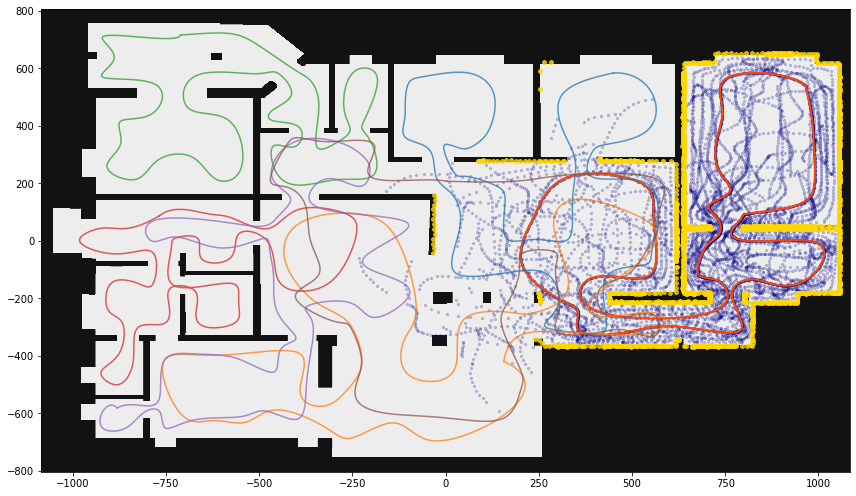

In [7]:
(fig, ax) = plt.subplots(figsize=(12,7), tight_layout=True)
X, Y = np.meshgrid(lidar.xs, lidar.ys)
ax.contourf(X, Y, lidar.img, cmap=cm.binary, zorder=0)

ax.plot(datasets[0].scan_locs[:, 0], datasets[0].scan_locs[:, 1],
    c="orangered", linewidth=2, zorder=2)

scan_points = datasets[0].scans[::factor, :]
ld_points = scan_points[scan_points[:, 2] != 1.0]
hd_points = scan_points[scan_points[:, 2] == 1.0]
print (len(hd_points))
ax.scatter(ld_points[:, 0], ld_points[:, 1], s=5, color="darkblue", alpha=0.2, zorder=2)
ax.scatter(hd_points[:, 0], hd_points[:, 1], s=15, color="gold", alpha=0.8, zorder=2)
for ds in datasets[1:]:
    ax.plot(ds.scan_locs[:, 0], ds.scan_locs[:, 1], alpha=0.75, linewidth=1.5, zorder=3)

In [8]:
fig.savefig("lidar_paperfig.pdf", dpi=500.0)

In [6]:
# 7 datasets 
n = 7
train_set = [[] for i in range(n)]
test_set = [[] for i in range(n)]
train_f = 3
test_f = 61
for idx in range(7):
    scan_points = datasets[idx].scans[::train_f, :]
    train_set[idx].append(scan_points)
    scan_points = datasets[idx].scans[::test_f, :]
    test_set[idx].append(scan_points)

In [7]:
print (len(train_set), np.array(train_set[3][0]).shape)

7 (45000, 3)


In [8]:
test_set = np.concatenate([arr[0] for arr in test_set], axis=0)
print (test_set.shape)

(15792, 3)


2502


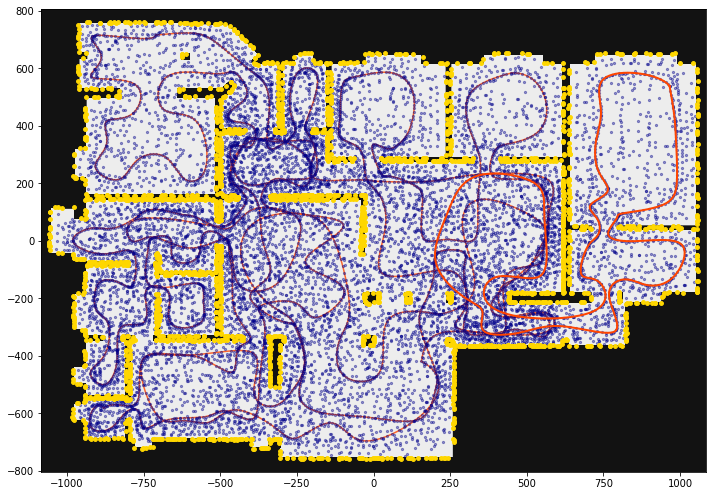

In [9]:
(fig, ax) = plt.subplots(figsize=(10,7), tight_layout=True)
X, Y = np.meshgrid(lidar.xs, lidar.ys)
ax.contourf(X, Y, lidar.img, cmap=cm.binary, zorder=0)

ax.plot(datasets[0].scan_locs[:, 0], datasets[0].scan_locs[:, 1],
    c="orangered", linewidth=2, zorder=3)

scan_points = test_set
ld_points = scan_points[scan_points[:, 2] != 1.0]
hd_points = scan_points[scan_points[:, 2] == 1.0]
print (len(hd_points))
ax.scatter(ld_points[:, 0], ld_points[:, 1], s=5, color="darkblue", alpha=0.4, zorder=2)
ax.scatter(hd_points[:, 0], hd_points[:, 1], s=15, color="gold", alpha=1.0, zorder=2)
for ds in datasets[1:]:
    ax.plot(ds.scan_locs[:, 0], ds.scan_locs[:, 1], c="orangered", alpha=0.8, zorder=1)

In [10]:
import os
import pickle
# Replace the following with __file__ constant in next 
cur_path = os.getcwd()

new_path = os.path.relpath(r'..\\..\\results\\dinno_dgvidp_nf_1000l1.pcl', cur_path)
print (new_path)

..\..\results\dinno_dgvidp_nf_1000l1.pcl


In [11]:
file = open(new_path,'rb')
data_dict = pickle.load(file)
print (data_dict.keys())
A = data_dict['A']
print (A)

dict_keys(['A', 'train', 'verify', 'test', 'features', 'mu', 'cov', 'error', 'lscale'])
[[0.09573478 0.16418318 0.         0.26463623 0.1729264  0.13228325
  0.17049206]
 [0.16376607 0.28085545 0.26343899 0.         0.         0.
  0.29164756]
 [0.         0.26325232 0.24692747 0.         0.27727125 0.21210377
  0.        ]
 [0.26602512 0.         0.         0.73536377 0.         0.
  0.        ]
 [0.17245441 0.         0.27741531 0.         0.3115056  0.23829197
  0.        ]
 [0.13192484 0.         0.21221823 0.         0.23829675 0.18228951
  0.23494217]
 [0.17009477 0.29170905 0.         0.         0.         0.2350315
  0.30291821]]


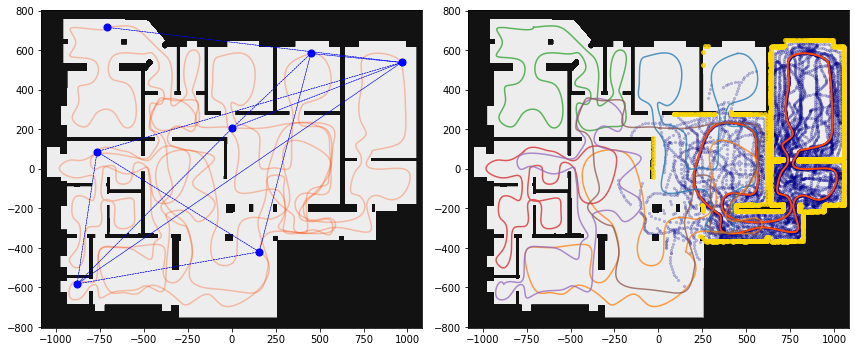

In [16]:
(fig, ax) = plt.subplots(1,2,figsize=(12,5), tight_layout=True)
X, Y = np.meshgrid(lidar.xs, lidar.ys)
ax[1].contourf(X, Y, lidar.img, cmap=cm.binary, zorder=0)

ax[1].plot(datasets[0].scan_locs[:, 0], datasets[0].scan_locs[:, 1],
    c="orangered", linewidth=2, zorder=2)

scan_points = datasets[0].scans[::factor, :]
ld_points = scan_points[scan_points[:, 2] != 1.0]
hd_points = scan_points[scan_points[:, 2] == 1.0]

ax[1].scatter(ld_points[:, 0], ld_points[:, 1], s=5, color="darkblue", alpha=0.2, zorder=2)
ax[1].scatter(hd_points[:, 0], hd_points[:, 1], s=15, color="gold", alpha=0.8, zorder=2)
for ds in datasets[1:]:
    ax[1].plot(ds.scan_locs[:, 0], ds.scan_locs[:, 1], alpha=0.75, linewidth=1.5, zorder=3)
    
    
ax[0].contourf(X, Y, lidar.img, cmap=cm.binary, zorder=0)
for ds in datasets:
    ax[0].plot(ds.scan_locs[:, 0], ds.scan_locs[:, 1], linewidth=1.5, 
            alpha=0.3, c="orangered", zorder=2)

n = len(datasets)
init_pos = np.zeros((n,2))
for idx, ds in enumerate(datasets):
    init_pos[idx, :] = ds.scan_locs[0, :]
    ax[0].scatter(init_pos[idx, 0], init_pos[idx, 1], c='b', s=50, zorder=4)
    
for i in range(n):
    for j in range(n):
        if A[i,j]>0:
            ax[0].plot([init_pos[i,0], init_pos[j,0]],
                    [init_pos[i,1], init_pos[j,1]], 
                    c='blue', linestyle='--', linewidth=0.5, zorder=4)

In [13]:
from platform import python_version

print(python_version())

3.9.1
